In [71]:
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import collections, colors, transforms
from pprint import pprint
import statistics
from datetime import datetime
import os
import random

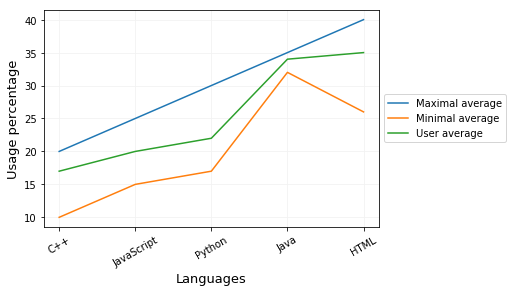

In [80]:
## class for extracting the repo is written here!

class Analyser:
    
    def __init__(self,repo,user):
        self.repo = repo
        self.user = user
        self.repofile = f'{repo}_users_repo_complete_data.json'
        print(self.repo,self.user,self.repofile)
    
    def getFileData(self,filename = ""):
        RepoData = {}
        if filename == "":
            with open(f"ui/data/{self.repofile}",) as inpFile:
                RepoData = json.load(inpFile)
            return RepoData
        else:
            with open(f"ui/data/{filename}",) as inpFile:
                RepoData = json.load(inpFile)
            return RepoData
    
    def ContributorsChart(self,Z, filename):
        plt.figure(figsize=(20,3))
        plt.pcolormesh(Z, cmap='YlGn')
        plt.title('Contribution chart', fontweight ="bold")
        ax = plt.gca;
        days = ["Sat", "Fri", "Thur", "Wed", "Tues", "Mon", "Sun"];
        plt.yticks(np.arange(0.5, 7.5, step=1), days)
        plt.savefig(filename, dpi=600, bbox_inches='tight', pad_inches=0)
        plt.show()
        
    def LanguageChart(self,results, category_names, filename):
        labels = list(results.keys())
        data = np.array(list(results.values()))
        data_cum = data.cumsum(axis=1)
        category_colors = plt.get_cmap('RdYlGn')(
          np.linspace(0.15, 0.85, data.shape[1]))

        fig, ax = plt.subplots(figsize=(10, 1))
        ax.invert_yaxis()
        ax.xaxis.set_visible(False)
        ax.set_xlim(0, np.sum(data, axis=1).max())

        for i, (colname, color) in enumerate(zip(category_names, category_colors)):
          widths = data[:, i]
          starts = data_cum[:, i] - widths
          ax.barh(labels, widths, left=starts, height=0.5,
                  label=colname, color=color)
          xcenters = starts + widths / 2

          r, g, b, _ = color
          text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
          for y, (x, c) in enumerate(zip(xcenters, widths)):
              ax.text(x, y, str(int(c)), ha='center', va='center',
                      color=text_color)
        ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
                loc='lower left', fontsize='small')
        plt.savefig(filename, dpi=600, bbox_inches='tight', pad_inches=0)
        return fig, ax
    
    def SplitChart (self,category_names, min_values, max_values, mean_values, xlabel, ylabel, filename):
        plt.grid(color='#F2F2F2', alpha=1, zorder=0)
        plt.plot(category_names, max_values, label = "Maximal average")
        plt.plot(category_names, min_values, label = "Minimal average")
        plt.plot(category_names, mean_values, label = "User average")
        plt.xlabel(xlabel, fontsize=13)
        plt.xticks(rotation=30)
        plt.ylabel(ylabel, fontsize=13)
        #plt.legend()
        plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(filename, dpi=600, bbox_inches='tight', pad_inches=0)
        plt.show()
    
    def ContributorsContributionGraph(self,filename = ""):
        np_contribution_data = []
        repoData = {}
        if filename == "":
            repoData = self.getFileData()
        else:
            repoData = self.getFileData(filename)
        #print(repoData)
        totalContributor = len(repoData)
        for userData in repoData.values():
            contribution_details = userData["contributions"]["data"]["user"]["contributionsCollection"]["contributionCalendar"]["weeks"]
            #pprint(contribution_details)
            
            contribution_data = []
            
            for weeklydict in contribution_details:
                weeklyContribution = []
                weeklyData = weeklydict['contributionDays']
                
                for dailydict in weeklyData:
                    weeklyContribution.append(dailydict['contributionCount'])
                
                while len(weeklyContribution) < 7:
                    weeklyContribution.append(0)
                
                contribution_data.append(weeklyContribution)
            temp = np.transpose(np.array(contribution_data)) 
            #print(temp)
            np_contribution_data.append(temp)
        
        avg_data = np.zeros((7,53),dtype = int)
        
        for data in np_contribution_data:
            avg_data = avg_data.__add__(data)
        
        avg_data = np.true_divide(avg_data,totalContributor)
        
        self.ContributorsChart(avg_data,"contrichart")
    
    def languageData(self):
        repoData = self.getFileData(f"{self.repo}_main_data.json")
        
        repo_languages = repoData['languages']
        
        languagesList = []
        languagePerList = []
        totalLine = 0
        for key,value in repo_languages.items():
            languagesList.append(key)
            languagePerList.append(value)
            totalLine +=value
            
        languagePerList[:] = ["{0:.2f}%".format(x*100 / totalLine) for x in languagePerList]
        print(languagesList,languagePerList)
        
        
    def ContributerTypeData(self):
        
        data = self.getFileData()
        userTypeDict = {}
        userList = []
        userTypeList = []
        
        for user, userdata in data.items():
            
            if userdata["company"] is not None:
                if "Professional" not in userTypeDict.keys():
                    userTypeDict["Professional"] = 1
                else:
                    userTypeDict["Professional"] += 1
            else:
                if userdata['type'] not in userTypeDict.keys():
                    userTypeDict[userdata['type']] = 1
                else:
                    userTypeDict[userdata['type']] += 1
        print(userTypeDict)  
        total_accounts = 0
        for key,values in userTypeDict.items():
            userTypeList.append(key)
            userList.append(values)
            total_accounts += values
        
        userList[:] = ["{0:.2f}%".format(x*100/total_accounts) for x in userList]
        return userTypeList, userList        
     
    def CommitsPerDayAvg(self,filename = ""):
        
        repoData = {}
        if filename == "":
            repoData = self.getFileData()
        else:
            repoData = self.getFileData(filename)
        
        totalContributor = len(repoData)
        commitsList = []
        for userData in repoData.values():
            total_days = 0
            commit = 0
            contribution_details = userData["contributions"]["data"]["user"]["contributionsCollection"]["contributionCalendar"]["weeks"]
            for weeklydict in contribution_details:
                for dailydict in weeklydict['contributionDays']:
                    total_days += 1
                    commit += (dailydict['contributionCount'])
            
            commitsList.append(commit/ total_days)
        
        if filename != "":
            return statistics.mean(commitsList)
        
        commits_stdev = 0 if len(commitsList) <= 1 else statistics.stdev(commitsList)
        commits_mean = statistics.mean(commitsList)
        
        lower_limit = commits_mean - commits_stdev if commits_mean - commits_stdev > 0 else 0
        upper_limit = commits_mean + commits_stdev
        
        print(lower_limit,upper_limit)
        
        return "{0:.2f}".format(lower_limit), "{0:.2f}".format(upper_limit)
    
    def OpenSourceProjectCount(self,filename = ""):
        
        repoData = {}
        if filename == "":
            repoData = self.getFileData()
        else:
            repoData = self.getFileData(filename)
        
        totalContributor = len(repoData)
        projectCountList = []
        for userData in repoData.values():
            repos = len(userData['repos'].values())
            projectCountList.append(repos)
            print(repos)
        
        if filename != "":
            return statistics.mean(projectCountList)
        
        project_stdev = statistics.stdev(projectCountList) if len(projectCountList) > 1 else 0
        project_mean = statistics.mean(projectCountList)
        
        lower_limit = project_mean - project_stdev if project_mean - project_stdev > 0 else 0
        upper_limit = project_mean + project_stdev
        
        print(lower_limit,upper_limit)
        
        return "{0:.2f}".format(lower_limit), "{0:.2f}".format(upper_limit)
    
    def UserPublicRepoCount(self,filename = ""):
        
        repoData = {}
        if filename == "":
            repoData = self.getFileData()
        else:
            repoData = self.getFileData(filename)
        
        totalContributor = len(repoData)
        projectCountList = []
        for userData in repoData.values():
            repos = userData['public_repos']
            projectCountList.append(repos)
            print(repos)
        
        if filename != "":
            return statistics.mean(projectCountList)
        
        project_stdev = statistics.stdev(projectCountList) if len(projectCountList) > 1 else 0
        project_mean = statistics.mean(projectCountList)
        
        lower_limit = project_mean - project_stdev if project_mean - project_stdev > 0 else 0
        upper_limit = project_mean + project_stdev
        
        print(lower_limit,upper_limit)
        
        return "{0:.2f}".format(lower_limit), "{0:.2f}".format(upper_limit)        
     
    def AccountAge(self,filename = ""):
        repoData = {}
        if filename == "":
            repoData = self.getFileData()
        else:
            repoData = self.getFileData(filename)
        
        totalContributor = len(repoData)
        projectCountList = []
        today = datetime.utcnow().year
        for userData in repoData.values():
            date = int(userData['created_at'].split('-')[0])
            projectCountList.append(today - date)
            print(date)
        
        if filename != "":
            return statistics.mean(projectCountList)
        
        project_stdev = statistics.stdev(projectCountList) if len(projectCountList) > 1 else 0
        project_mean = statistics.mean(projectCountList)
        
        lower_limit = project_mean - project_stdev if project_mean - project_stdev > 0 else 0
        upper_limit = project_mean + project_stdev
        
        print(lower_limit,upper_limit)
        
        return "{0:.2f}".format(lower_limit), "{0:.2f}".format(upper_limit)
    
    def FollowersCount(self,filename = ""):
        repoData = {}
        if filename == "":
            repoData = self.getFileData()
        else:
            repoData = self.getFileData(filename)
        totalContributor = len(repoData)
        projectCountList = []
        for userData in repoData.values():
            repos = userData['followers']
            projectCountList.append(repos)
        
        if filename != "":
            return statistics.mean(projectCountList)
        project_stdev = statistics.stdev(projectCountList) if len(projectCountList) > 1 else 0
        project_mean = statistics.mean(projectCountList)
        
        lower_limit = project_mean - project_stdev if project_mean - project_stdev > 0 else 0
        upper_limit = project_mean + project_stdev
        
        print(lower_limit,upper_limit)
        
        return "{0:.2f}".format(lower_limit), "{0:.2f}".format(upper_limit)
     
    
    def getExtension(self,path):
        filename, file_extension = os.path.splitext(path)
        return file_extension
    
    def TypeClassfier(self,extension):
        
        if extension == '.ts':
            return "typescript"
        elif extension == '.md' or extension == '.txt':
            return "documentation"
        elif extension == '.cpp' or extension == 'cxx':
            return "c++"
        elif extension == '.c' or extension == '.h':
            return "c"
        elif extension == '.html':
            return "html"
        elif extension == '.js':
            return "javascript"
        elif extension == '.css':
            return "css"
        elif extension == '.py':
            return "python"
        elif extension == '.java':
            return "java"
        else:
            return "others"
    
    def sorted_lists(self, list1, list2):
        zipped_lists = zip(list1, list2)
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        list1, list2 = [ list(tuple) for tuple in  tuples]
        list1.reverse()
        list2.reverse()
        return list1,list2
    
    def FileTypeAnalyser(self,filename = ""):
        repoData = {}
        if filename == "":
            repoData = self.getFileData()
        else:
            repoData = self.getFileData(filename)
        usersAvg_dict = {}
        total_users = len(repoData.keys())
        
        for userData in repoData.values():
            
            usersRepo = userData['repos']
            #pprint(usersRepo)
            repo_file_dict = {}
            total_user_repos = len(usersRepo.keys())
            for data in usersRepo.values():
                file_dict = {}
                commitData = data['commit_files']
                total_files = len(commitData)
                if total_files == 0:
                    total_user_repos -= 1
                    continue
                
                for commit in commitData:
                    extension = self.getExtension(commit['filename'])
                    #print(extension)
                    filetype = self.TypeClassfier(extension)
                    
                    if filetype not in file_dict.keys():
                        file_dict[filetype] = 1
                    else:
                        file_dict[filetype] += 1
                t2 = 0
                for key,values in file_dict.items():
                    file_dict[key] = values/ total_files
                    t2 += file_dict[key]
                    if key not in repo_file_dict.keys():
                        repo_file_dict[key] = file_dict[key]
                    else:
                        repo_file_dict[key] += file_dict[key]
            t1 = 0    
            for key,values in repo_file_dict.items():    
                repo_file_dict[key] = values/ total_user_repos
                t1 += repo_file_dict[key]
                if key not in usersAvg_dict.keys():
                    usersAvg_dict[key] = repo_file_dict[key]
                else:
                    usersAvg_dict[key] += repo_file_dict[key]
    
        total = 0
        fileNameList = []
        filePercentList = []
        for key,value in usersAvg_dict.items():
            usersAvg_dict[key] = value/total_users
            total += usersAvg_dict[key]
            
            fileNameList.append(key)
            filePercentList.append("{0:.2f}".format(usersAvg_dict[key]))
        
        return self.sorted_lists(filePercentList,fileNameList)
        
    def makeLanguageCharts(self,filename):
        
        userData = self.getFileData(filename)
        userName = ""
        for key in userData.keys():
            userName = key
            
        userPercentList,userFileList = self.FileTypeAnalyser(filename)
        RepoPercentList,RepoListList = self.FileTypeAnalyser()
        
        userPercentList[:] = [int(float(x)*100) for x in userPercentList]
        RepoPercentList[:] = [int(float(x)*100) for x in RepoPercentList]
        self.LanguageChart({f'{self.user}/{self.repo}': RepoPercentList},RepoListList,"RepoLanguage")
        self.LanguageChart({'{userName}': userPercentList},userFileList,"UserLanguage")
    
    def detailedGraph(self,filename):
        
        category_names = ['Commits per day', 'Open source projects',
                    'Public repositories', 'Account age', 'Followers']
        min_values = []
        max_values = []
        user_values = []
        temp_max = 0
        for category in category_names:
            min = 0
            max = 0
            user_data = 0
            if category == 'Commits per day':
                min,max = self.CommitsPerDayAvg()
                user_data = self.CommitsPerDayAvg(filename)
            if category == 'Open source projects':
                min,max = self.OpenSourceProjectCount()
                user_data = self.OpenSourceProjectCount(filename)
                
            if category == 'Public repositories':
                min,max = self.UserPublicRepoCount()
                user_data = self.UserPublicRepoCount(filename)
                
            if category == 'Account age':
                min,max = self.AccountAge()
                user_data = self.AccountAge(filename)
                
            if category == 'Followers':
                min,max = self.FollowersCount()
                user_data = self.FollowersCount(filename)
            print(min,max,user_data)
            min = float(min)
            max = float(max)
            user_data = float(user_data)
            
            print(min,max,user_data)
            temp_max = (max + ((random.randrange(2,4))/10 * max)) if max > user_data else user_data
            temp_max = temp_max/10
            min_values.append((min*100)/temp_max)
            max_values.append((max*100)/temp_max)
            user_values.append((user_data*100)/temp_max)
        
        print(min_values,max_values,user_values)
        self.SplitChart(category_names, min_values, max_values, user_values, "Languages", "Usage percentage", "samplechart")       

category_names = ['C++', 'JavaScript',
                    'Python', 'Java', 'HTML']
min_values =  [10, 15, 17, 32, 26]
max_values = [20, 25, 30, 35, 40]
mean_values = [17, 20, 22, 34, 35]
analyser.SplitChart (category_names, min_values, max_values, mean_values, "Languages", "Usage percentage", "samplechart")      
        

SE-gamedev arpit1912 SE-gamedev_users_repo_complete_data.json


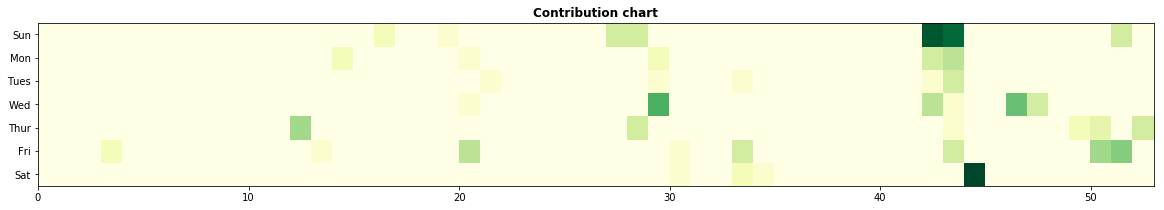

{'User': 1}
0.43989071038251365 0.43989071038251365
commits  ('0.44', '0.44')
5
5 5
Open Source  ('5.00', '5.00')
7
7 7
Public Repo  ('7.00', '7.00')
2019
2 2
Account age  ('2.00', '2.00')
0 0
Follower Count  ('0.00', '0.00')
 File analysis  (['0.67', '0.20', '0.07', '0.03', '0.02', '0.01'], ['others', 'javascript', 'python', 'css', 'documentation', 'html'])

user's data here



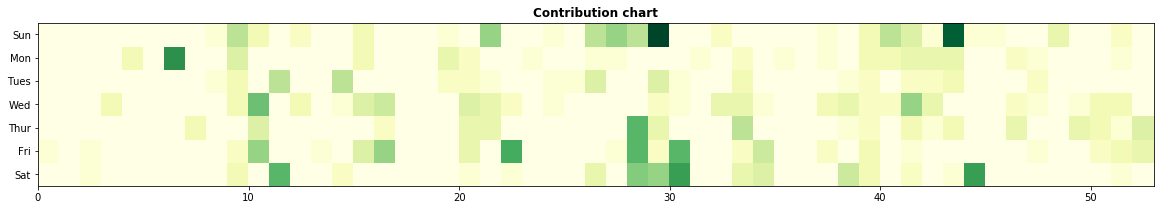

user's commits  1.5765027322404372
2
user's Open Source  2
21
user's Public Repo  21
2019
user's Account age  2
user's Follower Count  6
user's File analysis  (['0.46', '0.24', '0.13', '0.07', '0.07', '0.03'], ['typescript', 'others', 'javascript', 'java', 'documentation', 'html'])
0.43989071038251365 0.43989071038251365
0.44 0.44 1.5765027322404372
5
5 5
2
5.0 5.0 2.0
7
7 7
21
7.0 7.0 21.0
2019
2 2
2019
2.0 2.0 2.0
0 0
0.0 0.0 6.0
[279.0987868284228, 769.2307692307692, 333.3333333333333, 1000.0, 0.0] [279.0987868284228, 769.2307692307692, 333.3333333333333, 1000.0, 0.0] [1000.0, 307.6923076923077, 1000.0, 1000.0, 1000.0]


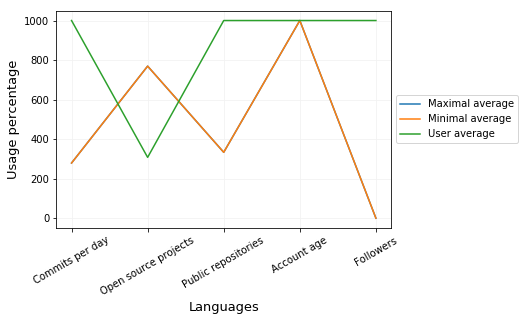

In [81]:
analyser = Analyser("SE-gamedev","arpit1912")
analyser.ContributorsContributionGraph()
analyser.ContributerTypeData()
print("commits ",analyser.CommitsPerDayAvg())
print("Open Source ",analyser.OpenSourceProjectCount())
print("Public Repo ",analyser.UserPublicRepoCount())
print("Account age ",analyser.AccountAge())
print("Follower Count ",analyser.FollowersCount())
print(" File analysis ",analyser.FileTypeAnalyser())
#analyser.FileTypeAnalyser()

print("\nuser's data here\n")

analyser.ContributorsContributionGraph("user_complete_data.json")
print("user's commits ",analyser.CommitsPerDayAvg("user_complete_data.json"))
print("user's Open Source ",analyser.OpenSourceProjectCount("user_complete_data.json"))
print("user's Public Repo ",analyser.UserPublicRepoCount("user_complete_data.json"))
print("user's Account age ",analyser.AccountAge("user_complete_data.json"))
print("user's Follower Count ",analyser.FollowersCount("user_complete_data.json"))
print("user's File analysis ",analyser.FileTypeAnalyser("user_complete_data.json"))
#analyser.makeLanguageCharts("user_complete_data.json")
analyser.detailedGraph("user_complete_data.json")

In [ ]:
Z = np.random.rand(7, 52)
ContributorsChart(Z, "contrichart")

(<Figure size 720x72 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22ce8cdf240>)

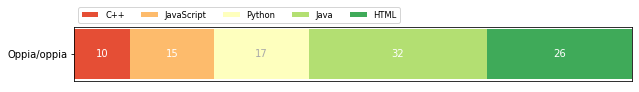

In [48]:
category_names = ['C++', 'JavaScript',
                    'Python', 'Java', 'HTML']
results = {
      'Oppia/oppia': [10, 15, 17, 32, 26]
}

analyser.LanguageChart(results, category_names, "language")


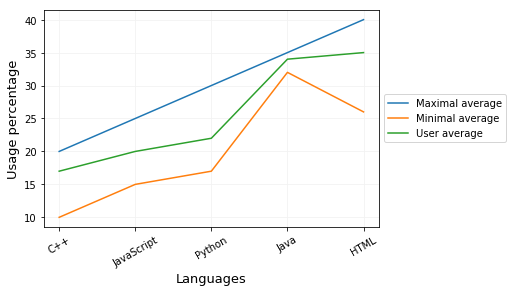

In [49]:
category_names = ['C++', 'JavaScript',
                    'Python', 'Java', 'HTML']
min_values =  [10, 15, 17, 32, 26]
max_values = [20, 25, 30, 35, 40]
mean_values = [17, 20, 22, 34, 35]
analyser.SplitChart (category_names, min_values, max_values, mean_values, "Languages", "Usage percentage", "samplechart")